In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [14]:
import sys
sys.path.append('../mmocr_text/')
sys.path.append('../')

from mmocr.apis import TextDetInferencer
inferencer = TextDetInferencer(model='DBNetPP', weights='../mmocr_text/ckpts/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth')
poly_list = inferencer('/home/linjw/WorkSpace/product_text_refine-master/example/1690784723456_3_ref.png')['predictions'][0]['polygons']

Loads checkpoint by local backend from path: ../mmocr_text/ckpts/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth


/home/linjw/anaconda3/envs/pytorch/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/linjw/anaconda3/envs/pytorch/lib/python3.9/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [15]:
poly = poly_list[0]
min_area=50
poly = np.array(poly).round().astype(np.int32).reshape(-1, 2)
area = cv2.contourArea(poly, True)

In [16]:
poly

array([[532, 571],
       [532, 560],
       [563, 560],
       [563, 571]], dtype=int32)

In [17]:
def points_to_box(points):
    points = np.array(points).round().astype(np.int32).reshape(-1, 2)
    # 找到四个点中的最小和最大 x 和 y 坐标值
    x_values = points[:, 0]
    y_values = points[:, 1]
    x_min = np.min(x_values)
    x_max = np.max(x_values)
    y_min = np.min(y_values)
    y_max = np.max(y_values)

    # 创建表示矩形框的NumPy数组
    input_box = np.array([x_min, y_min, x_max, y_max])

    return input_box

# 调用函数并打印结果
input_box = points_to_box(poly)
input_box

array([532, 560, 563, 571], dtype=int32)

In [18]:
from mmocr.apis import TextDetInferencer
import cv2
import numpy as np
import torch
from PIL import Image
from loguru import logger
from utils import edge_blur, style_transfer, get_infer_map

class TextRefineInterface:
    def __init__(self, ckpt_path: str='mmocr/ckpts/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth'):
        self.device = torch.device('cuda:0')
        self.inferencer = TextDetInferencer(model='DBNetPP', weights=ckpt_path)

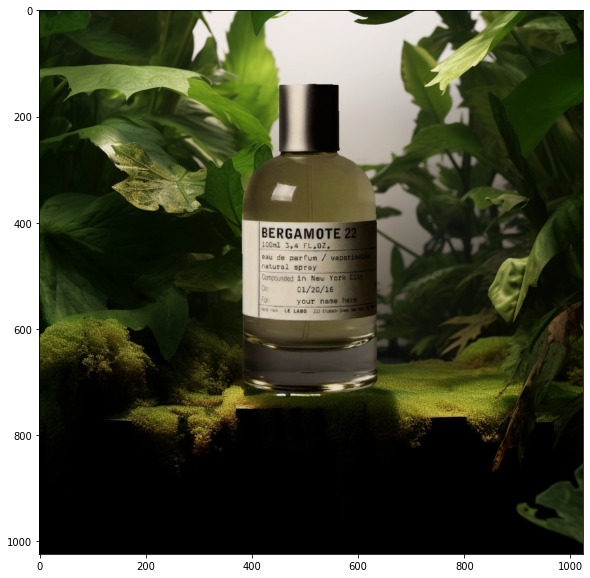

In [19]:
image = cv2.imread('/home/linjw/WorkSpace/product_text_refine-master/example/1690784723456_3_ref.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()


In [20]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"  # or  "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [21]:
predictor.set_image(image)

In [22]:
box_list = [points_to_box(x) for x in poly_list]

### 多方框 

In [23]:
input_boxes = torch.tensor(box_list, device=predictor.device)
print(image.shape)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)


(1024, 1024, 3)


/tmp/ipykernel_356569/2764835781.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_boxes = torch.tensor(box_list, device=predictor.device)


In [24]:
masks.shape

torch.Size([26, 1, 1024, 1024])

In [25]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

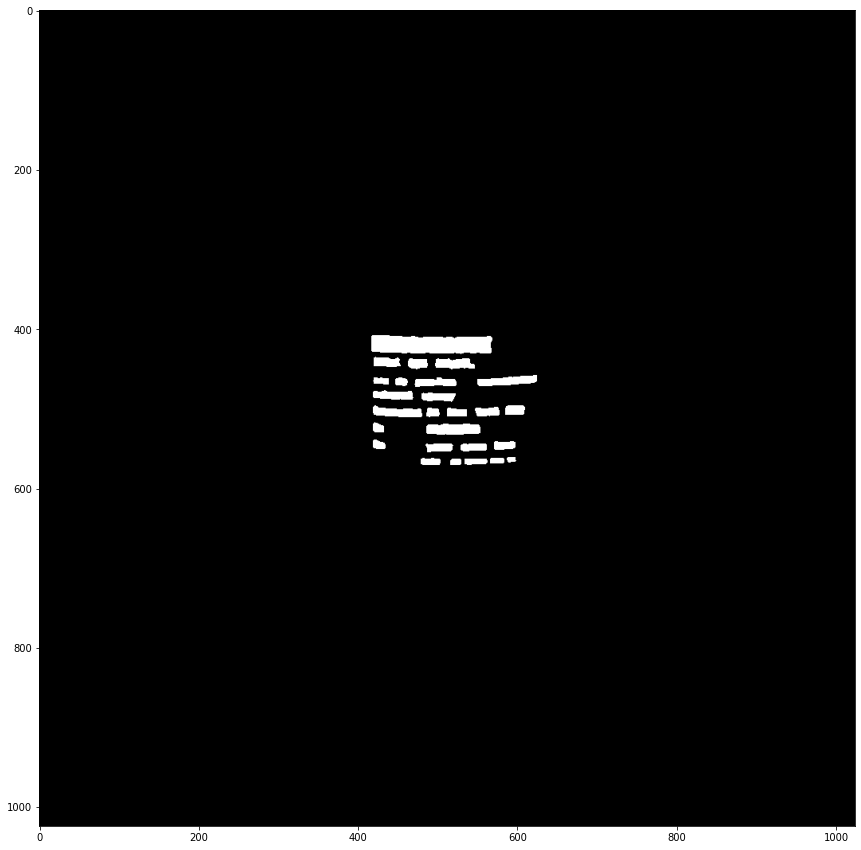

In [ ]:
# 假设你有一个存储掩码的张量 masks，其形状为（26, 1, 1024, 1024）
# masks = torch.randn(26, 1, 1024, 1024)  # 这里使用随机生成的掩码作为示例

# 将所有掩码相加以得到合并掩码
merged_mask = torch.sum(masks, dim=0)

# 转换为NumPy数组，并从第一个维度中移除尺寸为1的维度
merged_mask = merged_mask.squeeze().cpu().numpy()
plt.figure(figsize=(15, 15))
# 绘制合并后的掩码
plt.imshow(merged_mask, cmap='gray')
plt.show()
